In [1]:
%%capture
%pip install pyspark
from pyspark.sql import SparkSession
# You build a Spark Session that is later used to create a
# Spark dataframe
spark = SparkSession.builder.appName('Practice').getOrCreate()

In [2]:
# Update FILE_PATHS in 'imports.py' with the paths to the PUMS
# files before using this.
from imports import FILE_PATHS
files = FILE_PATHS
df = spark.read.csv(files,header=True,inferSchema=True)

# Current PySpark documentation says that you can input a path
# to a folder to import all files in said folder, but that
# seems to be outdated. I had to pass in a list of file paths
# instead.

### Variables Used
- Annual Wages (past 12 months) (WAGP)
- Race: White, or other combination (used for 'Minority Status') (RACWHT)

In [3]:
# To get mean value
from pyspark.sql.functions import avg
# To get median value
from pyspark.sql.functions import percentile_approx 

In [4]:
wages = (df
    .groupBy(df['ST'],df['RACWHT'])
    .agg(
        avg('WAGP').alias('avg_salary'),
        percentile_approx("WAGP", 0.5,accuracy=10000).alias('median')
    )
    .toPandas())

In [24]:
# STATE_MAPS makes this more readable
from imports import STATE_MAPS
wages['ST'] = wages['ST'].replace(STATE_MAPS)

wages['avg_salary'] = wages['avg_salary'].round(0)

# Not elegant, but it works. Divides the minority income
# ('RACWHT' == 0) by non-minority income ('RACWHT' == 1).
def div_list(input):
    return (input.loc[input['RACWHT']==0]['avg_salary'].values[0] / 
            input.loc[input['RACWHT']==1]['avg_salary'].values[0])

# Minority's income as percent of non-minority.
wages['discrepency'] = wages['ST'].apply(
    lambda x: div_list(wages.loc[wages['ST'] == x]))
wages = (wages
    .sort_values(by=['discrepency','ST','avg_salary'],ascending=False)
    .reset_index(drop=True))

In [25]:
wages.head(10)

,ST,RACWHT,avg_salary,median,discrepency
0,New Hampshire,0,27839.0,13000,1.018587
1,New Hampshire,1,27331.0,13000,1.018587
2,West Virginia,1,16505.0,1700,0.955226
3,West Virginia,0,15766.0,2500,0.955226
4,Oregon,1,22143.0,7000,0.920697
5,Oregon,0,20387.0,10000,0.920697
6,Washington,1,26668.0,10400,0.879181
7,Washington,0,23446.0,12000,0.879181
8,Kentucky,1,20341.0,6000,0.877341
9,Kentucky,0,17846.0,6700,0.877341


In [26]:
wages.tail(10)

,ST,RACWHT,avg_salary,median,discrepency
92,South Carolina,1,23131.0,8000,0.623968
93,South Carolina,0,14433.0,4500,0.623968
94,Louisiana,1,22771.0,7000,0.605068
95,Louisiana,0,13778.0,3000,0.605068
96,Mississippi,1,20988.0,5000,0.566085
97,Mississippi,0,11881.0,1300,0.566085
98,Alaska,1,29676.0,17700,0.534843
99,Alaska,0,15872.0,6400,0.534843
100,District of Columbia,1,60316.0,40000,0.377910
101,District of Columbia,0,22794.0,4000,0.377910


In [27]:
%%capture
%pip install seaborn
import seaborn as sns, matplotlib.pyplot as plt

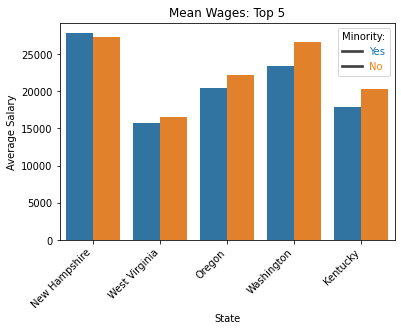

In [36]:
mean_plt = sns.barplot(x='ST',y='avg_salary',data=wages.head(10), hue='RACWHT').set(title='Mean Wages: Top 5')
plt.ylabel('Average Salary')
plt.xlabel('State')
plt.xticks(rotation=45, ha="right")
plt.legend(labelcolor=['tab:blue','tab:orange'],title='Minority:',labels=['Yes','No'])
plt.show()

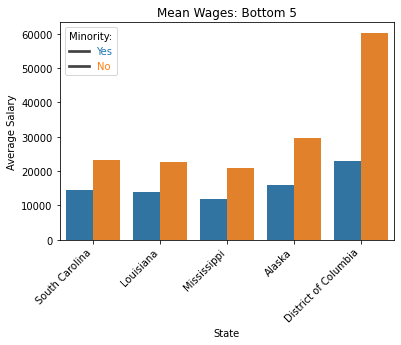

In [35]:
mean_plt = sns.barplot(x='ST',y='avg_salary',data=wages.tail(10), hue='RACWHT').set(title='Mean Wages: Bottom 5')
plt.ylabel('Average Salary')
plt.xlabel('State')
plt.xticks(rotation=45, ha="right")
plt.legend(labelcolor=['tab:blue','tab:orange'],title='Minority:',labels=['Yes','No'])
plt.show()

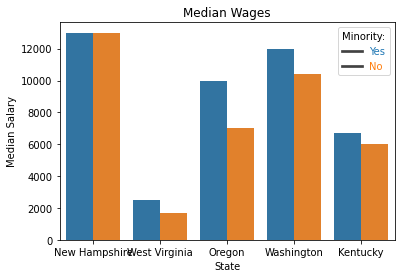

In [29]:
# Median does not seem to be accurate at the moment
median_plt = sns.barplot(x='ST',y='median',data=wages.head(10), hue='RACWHT').set(title='Median Wages')
plt.ylabel('Median Salary')
plt.xlabel('State')
plt.legend(labelcolor=['tab:blue','tab:orange'],title='Minority:',labels=['Yes','No'],)
plt.show()